Code to download and plot 30 years (1990-2020) of ATMOS Quality controlled 60-m tower data from https://www.atmos.anl.gov/ANLMET/text/

In [48]:
import numpy as np
import pandas as pd
import time
from datetime import timedelta, date
import wget
import matplotlib.pyplot as plt
import requests 
import os, glob
import re
import datetime 
import itertools

In [49]:
# Download Quality controlled data from ATMOS 60-m Tower
months = ["jan", "feb","mar","apr","may","jun","jul","aug","sep","oct","nov","dec"]
base_url = 'https://www.atmos.anl.gov/ANLMET/text/'
year = 1990
while year < 2021:
    print('downloading data for year',year)
    for month in months:
        to_download = base_url + str(year) + '/' + month + str(year)[-2:] + 'met.sum'
        response = requests.get(to_download)
        if response.status_code == 200:
            with open(f'atmos-tower-{year}-{month}.txt', 'wb') as file:
                file.write(response.content)     
        elif response.status_code ==  404:
            to_download = base_url + str(year) + '/' + month + str(year)[-2:] + 'met.data'
            response = requests.get(to_download, headers=headers)
            with open(f'{outdir}/atmos-tower-{year}-{month}.txt', 'wb') as file:
                file.write(response.content)                
        else:
            print(f'Error downloading {month}{year}met.data. Status code: {response.status_code}')            
    year+=1

downloading data for year 1990
downloading data for year 1991
downloading data for year 1992
downloading data for year 1993
downloading data for year 1994
downloading data for year 1995
downloading data for year 1996
downloading data for year 1997
downloading data for year 1998
downloading data for year 1999
downloading data for year 2000
downloading data for year 2001
downloading data for year 2002
downloading data for year 2003
downloading data for year 2004
downloading data for year 2005
downloading data for year 2006
downloading data for year 2007
downloading data for year 2008
downloading data for year 2009
downloading data for year 2010
downloading data for year 2011
downloading data for year 2012
downloading data for year 2013
downloading data for year 2014
downloading data for year 2015
downloading data for year 2016
downloading data for year 2017
downloading data for year 2018
downloading data for year 2019
downloading data for year 2020


In [50]:
months = ["jan", "feb","mar","apr","may","jun","jul","aug","sep","oct","nov","dec"]
months_number = np.arange(1,13)
col_names = ['time','AT60','WS60','WD60','WD_STD60','RH10','DP10','AT10','WS10','WD10','WD_STD10','ST10cm','ST1m','ST10ft','Pressure','RS','RN','Precip','z/l','stability']
days = [] # array to store the days when data is present 
metdata = [] #array to store hourly data
for year in range(1990,2021):
    print('reading data from year',year)
    for i in range(len(months)):
        #print(months[i])
        filename = '/home/spal/notebooks/CROCUS/metdata_QC/atmos-tower-'+str(year)+'-'+months[i]+'.txt'
        with open(filename) as f:
            for line in f:
                line=line.strip()
                if len(line) == 8: 
                    break # Do not read daily or hourly averages at the end of each file
                elif re.match(r"^\d+.*$",line):
                    nl = line.split()
                    if len(nl) < 10:
                        day = str(months_number[i])+'/'+nl[0]+'/'+str(year)
                        days.append(day)
                    elif len(nl) > 10:
                        metdata.append(nl)               
all_data = pd.DataFrame(metdata,columns=col_names)

reading data from year 1990
reading data from year 1991
reading data from year 1992
reading data from year 1993
reading data from year 1994
reading data from year 1995
reading data from year 1996
reading data from year 1997
reading data from year 1998
reading data from year 1999
reading data from year 2000
reading data from year 2001
reading data from year 2002
reading data from year 2003
reading data from year 2004
reading data from year 2005
reading data from year 2006
reading data from year 2007
reading data from year 2008
reading data from year 2009
reading data from year 2010
reading data from year 2011
reading data from year 2012
reading data from year 2013
reading data from year 2014
reading data from year 2015
reading data from year 2016
reading data from year 2017
reading data from year 2018
reading data from year 2019
reading data from year 2020


In [51]:
# create list of days for the dataframe
day_list = list(itertools.chain.from_iterable(itertools.repeat(x, 24) for x in days))
day_list = pd.to_datetime(day_list)

In [52]:
# create list of hours for dataframe
hours_str = pd.Series(np.arange(0,24)).astype(str).str.zfill(2)
hours_list = list(hours_str)*len(days)

In [53]:
# Add date and time to the dataframe
all_data['Date'] = pd.to_datetime(day_list, format='%m/%d/%Y', exact=False)
all_data['Time'] = hours_list  
all_data['datetime'] = pd.to_datetime(all_data['Date'].astype(str) + ' ' + all_data['Time'].astype(str))
all_data = all_data.set_index('datetime')
all_data = all_data.drop(['Date','Time'], axis=1)
# Shift the datetime to match with web format, 2400 is next day 0000
final_df = all_data.shift(1, freq='H') 

In [54]:
# Clean up data for plotting
final_df = final_df[~final_df["Precip"].str.contains('\*')]
final_df = final_df[~final_df["Precip"].str.contains('\^')]
final_df = final_df[~final_df["Precip"].str.contains('\?')]
final_df['Precip'] = final_df['Precip'].astype(float)
final_df.drop(final_df[final_df['Precip'] >= 200].index, inplace = True)

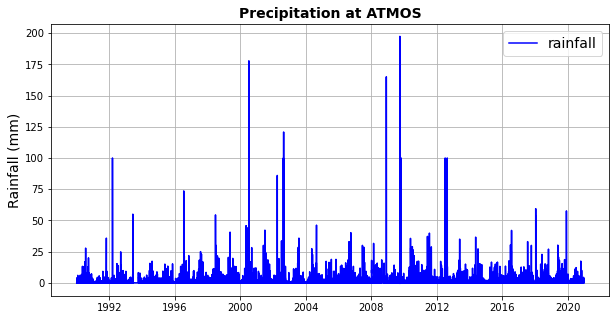

In [55]:
fig,ax1 = plt.subplots(figsize=(10,5))
ax1.plot(final_df.index,final_df['Precip'].values, label="rainfall",color='blue')
ax1.set_ylabel('Rainfall (mm)', fontsize =14)
ax1.set_title("Precipitation at ATMOS",fontweight="bold", fontsize=14)
ax1.legend(fontsize=14)
plt.grid()
plt.savefig('ATMOS_precip.png', dpi=300)

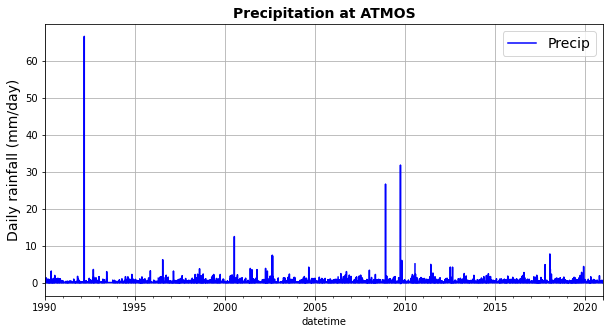

In [56]:
fig,ax1 = plt.subplots(figsize=(10,5))
final_df.resample('D').mean().plot(ax=ax1,label='rainfall',color='blue')
ax1.set_ylabel('Daily rainfall (mm/day)', fontsize =14)
ax1.set_title("Precipitation at ATMOS",fontweight="bold", fontsize=14)
ax1.legend(fontsize=14)
plt.grid()
plt.savefig('ATMOS_daily.png', dpi=300)